<a href="https://colab.research.google.com/github/sondhi16/link-prediction-for-parkinson-mouse-data/blob/main/link_prediction_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch

In [2]:
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-2.6.0+cu124.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.6.0+cu124.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.6.0+cu124.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.6.0+cu124.html


In [3]:
pip install node2vec

In [4]:
from google.colab import files
uploaded = files.upload()

Saving combined network.graphml to combined network.graphml


**VGAE METHOD CODE**

Epoch:   0 | Loss: 3.3518 | Val AUC: 0.4203 | Val AP: 0.4812
Epoch:  20 | Loss: 1.4471 | Val AUC: 0.5131 | Val AP: 0.5099
Epoch:  40 | Loss: 1.4215 | Val AUC: 0.4662 | Val AP: 0.4612
Epoch:  60 | Loss: 1.3760 | Val AUC: 0.5949 | Val AP: 0.5667
Epoch:  80 | Loss: 1.2090 | Val AUC: 0.6809 | Val AP: 0.6413
Epoch: 100 | Loss: 1.1363 | Val AUC: 0.7182 | Val AP: 0.6694
Epoch: 120 | Loss: 1.0898 | Val AUC: 0.7208 | Val AP: 0.6788
Epoch: 140 | Loss: 1.0909 | Val AUC: 0.7274 | Val AP: 0.6718
Epoch: 160 | Loss: 1.0751 | Val AUC: 0.7507 | Val AP: 0.7054
Epoch: 180 | Loss: 1.0538 | Val AUC: 0.7523 | Val AP: 0.7161

Test AUC: 0.7638 | Test AP: 0.7393


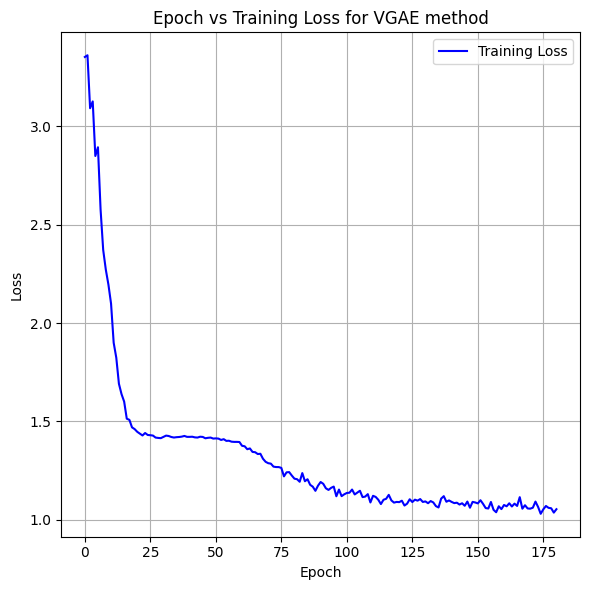

In [29]:
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import VGAE, GCNConv
from torch_geometric.transforms import Compose, NormalizeFeatures, ToDevice, RandomLinkSplit
from torch_geometric.utils import from_networkx
import networkx as nx
import matplotlib.pyplot as plt

np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

nx_graph = nx.read_graphml("combined network.graphml")
nx_graph = nx_graph.to_undirected() if nx.is_directed(nx_graph) else nx_graph

data = from_networkx(nx_graph)

if not hasattr(data, 'x') or data.x is None:
    data.x = torch.eye(data.num_nodes, dtype=torch.float)

transform = Compose([
    NormalizeFeatures(),
    ToDevice(device),
    RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                    split_labels=True, add_negative_train_samples=False)
])

train_data, val_data, test_data = transform(data)

class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.2):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

model = VGAE(Encoder(train_data.num_features, 16, dropout=0.2)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)
    loss = model.recon_loss(z, train_data.pos_edge_label_index)
    loss += (1 / train_data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    return model.test(z, data.pos_edge_label_index, data.neg_edge_label_index)

loss_values = []
for epoch in range(181):
    loss = train()
    loss_values.append(loss)
    val_auc, val_ap = test(val_data)
    if epoch % 20 == 0:
        print(f'Epoch: {epoch:>3} | Loss: {loss:.4f} | Val AUC: {val_auc:.4f} | Val AP: {val_ap:.4f}')

test_auc, test_ap = test(test_data)
print(f'\nTest AUC: {test_auc:.4f} | Test AP: {test_ap:.4f}')

plt.figure(figsize=(6, 6))
plt.plot(range(181), loss_values, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Training Loss for VGAE method')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

**GAE MEHOD CODE**


Epoch:   0 | Loss: 1.3859 | Val AUC: 0.4534 | Val AP: 0.4710
Epoch:  20 | Loss: 1.1549 | Val AUC: 0.6921 | Val AP: 0.6517
Epoch:  40 | Loss: 1.0469 | Val AUC: 0.7362 | Val AP: 0.7231
Epoch:  60 | Loss: 0.9849 | Val AUC: 0.7401 | Val AP: 0.7555
Epoch:  80 | Loss: 0.9646 | Val AUC: 0.7185 | Val AP: 0.7105
Epoch: 100 | Loss: 0.9385 | Val AUC: 0.7474 | Val AP: 0.7269
Epoch: 120 | Loss: 0.9376 | Val AUC: 0.7637 | Val AP: 0.7364
Epoch: 140 | Loss: 0.9235 | Val AUC: 0.7727 | Val AP: 0.7552

Test AUC: 0.7582 | Test AP: 0.7199


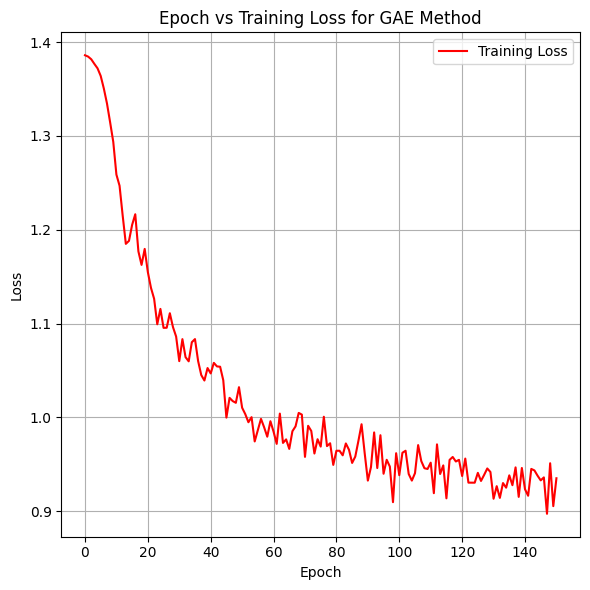

In [23]:
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import GAE, GCNConv
from torch_geometric.transforms import Compose, NormalizeFeatures, ToDevice, RandomLinkSplit
from torch_geometric.utils import from_networkx
import networkx as nx
import matplotlib.pyplot as plt

np.random.seed(42)
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

nx_graph = nx.read_graphml("combined network.graphml")
nx_graph = nx_graph.to_undirected() if nx.is_directed(nx_graph) else nx.Graph(nx_graph)
data = from_networkx(nx_graph)

if not hasattr(data, 'x') or data.x is None:
    data.x = torch.eye(data.num_nodes, dtype=torch.float)

transform = Compose([
    NormalizeFeatures(),
    ToDevice(device),
    RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                    split_labels=True, add_negative_train_samples=False)
])
train_data, val_data, test_data = transform(data)

class GAEEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.2):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        return self.conv2(x, edge_index)

model = GAE(GAEEncoder(train_data.num_features, 16, dropout=0.2)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)
    loss = model.recon_loss(z, train_data.pos_edge_label_index)
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    return model.test(z, data.pos_edge_label_index, data.neg_edge_label_index)

loss_values = []

for epoch in range(151):
    loss = train()
    loss_values.append(loss)
    val_auc, val_ap = test(val_data)
    if epoch % 20 == 0:
        print(f'Epoch: {epoch:>3} | Loss: {loss:.4f} | Val AUC: {val_auc:.4f} | Val AP: {val_ap:.4f}')

test_auc, test_ap = test(test_data)
print(f'\nTest AUC: {test_auc:.4f} | Test AP: {test_ap:.4f}')

plt.figure(figsize=(6, 6))
plt.plot(range(151), loss_values, label='Training Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Training Loss for GAE Method')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


SEAL METHOD

Epoch:   0 | Loss: 0.6881 | Val AUC: 0.7826 | Val AP: 0.7645
Epoch:   1 | Loss: 0.6405 | Val AUC: 0.7841 | Val AP: 0.7861
Epoch:   2 | Loss: 0.6311 | Val AUC: 0.7948 | Val AP: 0.7886
Epoch:   3 | Loss: 0.6265 | Val AUC: 0.7987 | Val AP: 0.7775
Epoch:   4 | Loss: 0.6243 | Val AUC: 0.7929 | Val AP: 0.7726
Epoch:   5 | Loss: 0.6197 | Val AUC: 0.8008 | Val AP: 0.7783
Epoch:   6 | Loss: 0.6197 | Val AUC: 0.7990 | Val AP: 0.7644
Epoch:   7 | Loss: 0.6148 | Val AUC: 0.8103 | Val AP: 0.7700
Epoch:   8 | Loss: 0.6136 | Val AUC: 0.8031 | Val AP: 0.7644
Epoch:   9 | Loss: 0.6120 | Val AUC: 0.8058 | Val AP: 0.7762
Epoch:  10 | Loss: 0.6075 | Val AUC: 0.8096 | Val AP: 0.7800

Test AUC: 0.7713 | Test AP: 0.7387


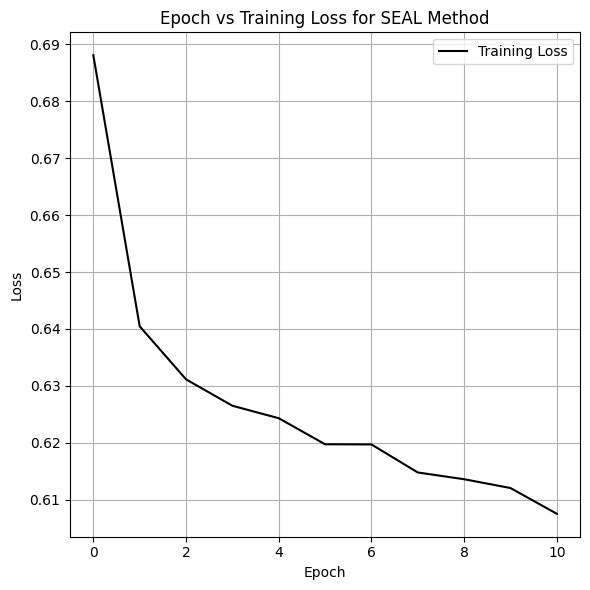

In [18]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.nn import Conv1d, MaxPool1d, Linear, Dropout, BCEWithLogitsLoss
from torch_geometric.utils import from_networkx, to_scipy_sparse_matrix, k_hop_subgraph
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import Compose, NormalizeFeatures, ToDevice, RandomLinkSplit
from torch_geometric.nn import GCNConv, aggr
from sklearn.metrics import roc_auc_score, average_precision_score
from scipy.sparse.csgraph import shortest_path
import networkx as nx
import matplotlib.pyplot as plt

np.random.seed(42)
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

nx_graph = nx.read_graphml("combined network.graphml")
nx_graph = nx_graph.to_undirected() if nx.is_directed(nx_graph) else nx.Graph(nx_graph)
data = from_networkx(nx_graph)

if not hasattr(data, 'x') or data.x is None:
    data.x = torch.eye(data.num_nodes, dtype=torch.float)

transform = Compose([
    NormalizeFeatures(),
    ToDevice(device),
    RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True, split_labels=True)
])
train_data, val_data, test_data = transform(data)

def seal_processing(data, edge_label_index, y):
    data_list = []
    for src_orig, dst_orig in edge_label_index.t().tolist():
        sub_nodes, sub_edge_index, mapping, _ = k_hop_subgraph(
            [src_orig, dst_orig], 2, data.edge_index, relabel_nodes=True)
        src, dst = mapping.tolist()

        mask1 = (sub_edge_index[0] != src) | (sub_edge_index[1] != dst)
        mask2 = (sub_edge_index[0] != dst) | (sub_edge_index[1] != src)
        sub_edge_index = sub_edge_index[:, mask1 & mask2]

        adj = to_scipy_sparse_matrix(sub_edge_index, num_nodes=sub_nodes.size(0)).tocsr()

        idx_wo_dst = [i for i in range(adj.shape[0]) if i != dst]
        adj_wo_dst = adj[idx_wo_dst, :][:, idx_wo_dst]
        src_reindexed = idx_wo_dst.index(src)
        d_src = shortest_path(adj_wo_dst, directed=False, unweighted=True, indices=src_reindexed)
        d_src = np.insert(d_src, dst, 0)

        idx_wo_src = [i for i in range(adj.shape[0]) if i != src]
        adj_wo_src = adj[idx_wo_src, :][:, idx_wo_src]
        dst_reindexed = idx_wo_src.index(dst)
        d_dst = shortest_path(adj_wo_src, directed=False, unweighted=True, indices=dst_reindexed)
        d_dst = np.insert(d_dst, src, 0)

        d_src = torch.tensor(d_src)
        d_dst = torch.tensor(d_dst)

        dist = d_src + d_dst
        z = 1 + torch.min(d_src, d_dst) + dist // 2 * (dist // 2 + dist % 2 - 1)
        z[src], z[dst], z[torch.isnan(z)] = 1., 1., 0.
        z = z.to(torch.long)

        node_labels = F.one_hot(z, num_classes=200).float()
        node_x = torch.cat([data.x[sub_nodes], node_labels], dim=1)

        data_obj = Data(x=node_x, z=z, edge_index=sub_edge_index, y=torch.tensor([y]))
        data_list.append(data_obj)

    return data_list

train_dataset = seal_processing(train_data, train_data.pos_edge_label_index, 1) + \
                seal_processing(train_data, train_data.neg_edge_label_index, 0)

val_dataset = seal_processing(val_data, val_data.pos_edge_label_index, 1) + \
              seal_processing(val_data, val_data.neg_edge_label_index, 0)

test_dataset = seal_processing(test_data, test_data.pos_edge_label_index, 1) + \
               seal_processing(test_data, test_data.neg_edge_label_index, 0)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

class DGCNN(torch.nn.Module):
    def __init__(self, dim_in, k=30):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, 32)
        self.gcn2 = GCNConv(32, 32)
        self.gcn3 = GCNConv(32, 32)
        self.gcn4 = GCNConv(32, 1)

        self.global_pool = aggr.SortAggregation(k=k)

        self.conv1 = Conv1d(1, 16, 97, 97)
        self.conv2 = Conv1d(16, 32, 5, 1)
        self.maxpool = MaxPool1d(2, 2)

        self.linear1 = Linear(352, 128)
        self.dropout = Dropout(0.5)
        self.linear2 = Linear(128, 1)

    def forward(self, x, edge_index, batch):
        h1 = self.gcn1(x, edge_index).tanh()
        h2 = self.gcn2(h1, edge_index).tanh()
        h3 = self.gcn3(h2, edge_index).tanh()
        h4 = self.gcn4(h3, edge_index).tanh()
        h = torch.cat([h1, h2, h3, h4], dim=-1)

        h = self.global_pool(h, batch)
        h = h.view(h.size(0), 1, h.size(-1))
        h = self.conv1(h).relu()
        h = self.maxpool(h)
        h = self.conv2(h).relu()
        h = h.view(h.size(0), -1)
        h = self.linear1(h).relu()
        h = self.dropout(h)
        return self.linear2(h).sigmoid()

model = DGCNN(train_dataset[0].num_features).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = BCEWithLogitsLoss()

def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out.view(-1), data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_dataset)

@torch.no_grad()
def test(loader):
    model.eval()
    y_true, y_pred = [], []
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        y_pred.append(out.view(-1).cpu())
        y_true.append(data.y.float().cpu())
    y_pred = torch.cat(y_pred)
    y_true = torch.cat(y_true)
    return roc_auc_score(y_true, y_pred), average_precision_score(y_true, y_pred)

loss_values = []
for epoch in range(11):
    loss = train()
    loss_values.append(loss)
    val_auc, val_ap = test(val_loader)
    if epoch % 1 == 0:
        print(f'Epoch: {epoch:>3} | Loss: {loss:.4f} | Val AUC: {val_auc:.4f} | Val AP: {val_ap:.4f}')

test_auc, test_ap = test(test_loader)
print(f'\nTest AUC: {test_auc:.4f} | Test AP: {test_ap:.4f}')

plt.figure(figsize=(6, 6))
plt.plot(range(11), loss_values, label='Training Loss', color='black')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Training Loss for SEAL Method')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

GAT METHOD

Epoch   0 | Loss: 0.6909 | Val AUC: 0.5612 | Val AP: 0.5954
Epoch  10 | Loss: 0.6911 | Val AUC: 0.5987 | Val AP: 0.5964
Epoch  20 | Loss: 0.6912 | Val AUC: 0.5844 | Val AP: 0.6013
Epoch  30 | Loss: 0.6911 | Val AUC: 0.5708 | Val AP: 0.6052
Epoch  40 | Loss: 0.6903 | Val AUC: 0.5616 | Val AP: 0.6007
Epoch  50 | Loss: 0.6880 | Val AUC: 0.5591 | Val AP: 0.5980
Epoch  60 | Loss: 0.6798 | Val AUC: 0.5790 | Val AP: 0.6032
Epoch  70 | Loss: 0.6539 | Val AUC: 0.6473 | Val AP: 0.6330
Epoch  80 | Loss: 0.6009 | Val AUC: 0.6637 | Val AP: 0.6627

Test AUC: 0.6913 | Test AP: 0.6530


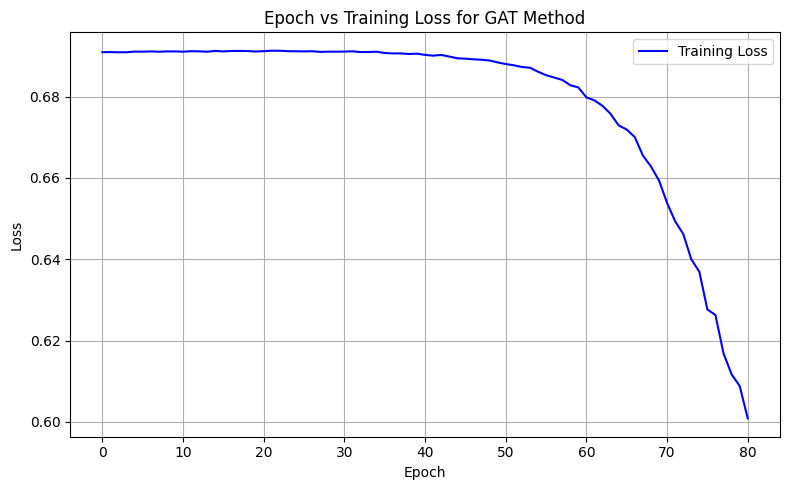

In [34]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.utils import from_networkx
from torch_geometric.transforms import RandomLinkSplit
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score

G = nx.read_graphml("combined network.graphml")
data = from_networkx(G)

if not hasattr(data, 'x') or data.x is None:
    data.x = torch.eye(data.num_nodes, dtype=torch.float)

transform = RandomLinkSplit(
    is_undirected=True,
    split_labels=True,
    add_negative_train_samples=True,
)
train_data, val_data, test_data = transform(data)

class GATEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GATEncoder, self).__init__()
        self.gat1 = GATConv(in_channels, 8, heads=8, dropout=0.2)
        self.gat2 = GATConv(8 * 8, out_channels, heads=1, concat=False, dropout=0.2)

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.gat2(x, edge_index)
        return x

def decode(z, edge_index):
    return (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)

@torch.no_grad()
def evaluate(model, data):
    model.eval()
    z = model(data.x, data.edge_index)
    pos_score = decode(z, data.pos_edge_label_index).sigmoid()
    neg_score = decode(z, data.neg_edge_label_index).sigmoid()
    y_pred = torch.cat([pos_score, neg_score])
    y_true = torch.cat([torch.ones(pos_score.size(0)), torch.zeros(neg_score.size(0))])
    auc = roc_auc_score(y_true.cpu(), y_pred.cpu())
    ap = average_precision_score(y_true.cpu(), y_pred.cpu())
    return auc, ap

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GATEncoder(in_channels=data.x.size(-1), out_channels=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)

losses = []

for epoch in range(81):
    model.train()
    optimizer.zero_grad()
    z = model(train_data.x, train_data.edge_index)
    pos_score = decode(z, train_data.pos_edge_label_index)
    neg_score = decode(z, train_data.neg_edge_label_index)
    score = torch.cat([pos_score, neg_score], dim=0)
    label = torch.cat([torch.ones(pos_score.size(0)), torch.zeros(neg_score.size(0))], dim=0).to(device)
    loss = F.binary_cross_entropy_with_logits(score, label)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if epoch % 10 == 0:
        val_auc, val_ap = evaluate(model, val_data)
        print(f"Epoch {epoch:3d} | Loss: {loss:.4f} | Val AUC: {val_auc:.4f} | Val AP: {val_ap:.4f}")

test_auc, test_ap = evaluate(model, test_data)
print(f"\nTest AUC: {test_auc:.4f} | Test AP: {test_ap:.4f}")

plt.figure(figsize=(8,5))
plt.plot(range(81), losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Training Loss for GAT Method')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Heuristic based link prediction methods


In [30]:
import networkx as nx
from sklearn.metrics import roc_auc_score, average_precision_score
import random
import math

G = nx.read_graphml("combined network.graphml")
G = nx.convert_node_labels_to_integers(G)

edges = list(G.edges())
non_edges = list(nx.non_edges(G))
random.shuffle(non_edges)

num_samples = min(len(edges), len(non_edges))
pos_edges = random.sample(edges, num_samples)
neg_edges = random.sample(non_edges, num_samples)

def jaccard(u, v):
    return len(set(G[u]) & set(G[v])) / len(set(G[u]) | set(G[v])) if len(set(G[u]) | set(G[v])) > 0 else 0

def common_neighbors(u, v):
    return len(list(nx.common_neighbors(G, u, v)))

def adamic_adar(u, v):
    return sum(1 / math.log(nx.degree(G, w)) for w in nx.common_neighbors(G, u, v) if nx.degree(G, w) > 1)

def preferential_attachment(u, v):
    return nx.degree(G, u) * nx.degree(G, v)

def compute_scores(method):
    scores, labels = [], []
    for u, v in pos_edges:
        labels.append(1)
        scores.append(method(u, v))
    for u, v in neg_edges:
        labels.append(0)
        scores.append(method(u, v))
    return scores, labels

for name, func in {
    'Common Neighbors': common_neighbors,
    'Jaccard Coefficient': jaccard,
    'Adamic-Adar': adamic_adar,
    'Preferential Attachment': preferential_attachment}.items():
    scores, labels = compute_scores(func)
    auc = roc_auc_score(labels, scores)
    ap = average_precision_score(labels, scores)
    print(f"{name:30s} AUC: {auc:.4f} | AP: {ap:.4f}")


Common Neighbors               AUC: 0.5924 | AP: 0.5731
Jaccard Coefficient            AUC: 0.5908 | AP: 0.5670
Adamic-Adar                    AUC: 0.5929 | AP: 0.5781
Preferential Attachment        AUC: 0.6352 | AP: 0.6233


Node2Vec + Random Forest Classifier Method for link prediction

In [17]:
import networkx as nx
import random
import numpy as np
from node2vec import Node2Vec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score
from tqdm import tqdm

G = nx.read_graphml("combined network.graphml")
G = G.to_undirected()

all_edges = list(G.edges())
non_edges = list(nx.non_edges(G))
random.seed(42)
neg_samples = random.sample(non_edges, len(all_edges))

pos_train, pos_test = train_test_split(all_edges, test_size=0.3, random_state=42)
neg_train, neg_test = train_test_split(neg_samples, test_size=0.3, random_state=42)

G_train = nx.Graph()
G_train.add_nodes_from(G.nodes())
G_train.add_edges_from(pos_train)

node2vec = Node2Vec(G_train, dimensions=64, walk_length=10, num_walks=100, workers=2, seed=42)
model = node2vec.fit(window=5, min_count=1)

def get_edge_embedding(u, v):
    return model.wv[u] * model.wv[v]

def make_dataset(edge_list, label):
    X, y = [], []
    for u, v in edge_list:
        if u in model.wv and v in model.wv:
            X.append(get_edge_embedding(u, v))
            y.append(label)
    return X, y
X_train_pos, y_train_pos = make_dataset(pos_train, 1)
X_train_neg, y_train_neg = make_dataset(neg_train, 0)
X_test_pos, y_test_pos = make_dataset(pos_test, 1)
X_test_neg, y_test_neg = make_dataset(neg_test, 0)

X_train = X_train_pos + X_train_neg
y_train = y_train_pos + y_train_neg
X_test = X_test_pos + X_test_neg
y_test = y_test_pos + y_test_neg

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_pred)
ap = average_precision_score(y_test, y_pred)

print(f"AUC: {auc:.4f}")
print(f"AP : {ap:.4f}")

Computing transition probabilities:   0%|          | 0/505 [00:00<?, ?it/s]

AUC: 0.6785
AP : 0.6680
